In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from argparse import ArgumentParser
from sklearn.utils import shuffle
from skimage.io import imread
import PIL

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as T
from torchvision import models

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# from torchsampler import ImbalancedDatasetSampler
# from torchmetrics.functional import auroc, precision, recall, f1_score, precision_recall_curve
import albumentations as albu
import albumentations.pytorch
import matplotlib.pyplot as plt
import torchmetrics
import timm
import random

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu


## Preprocess data

In [6]:
def preprocess_df(data_dir):
    df = pd.read_csv(os.path.join(data_dir,'breast-level_annotations.csv'))
    
#     df['img_path'] = f"{data_dir}/png/png/{df['study_id']}/{df['image_id']}.png"
    
    df['malignancy_label'] = df['breast_birads']
    # Define positive and negatives based on BI-RADS categories
    df.loc[df['malignancy_label'] == 'BI-RADS 1', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 2', 'malignancy_label'] = 0
    df.loc[df['malignancy_label'] == 'BI-RADS 3', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 4', 'malignancy_label'] = 1
    df.loc[df['malignancy_label'] == 'BI-RADS 5', 'malignancy_label'] = 1

    # Use pre-defined splits to separate data into development and testing
    train_df = df[df['split'] == 'training']
    test_df = df[df['split'] == 'test']
    
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

def show_image_pair(image1, image2):
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.imshow(image1)
    fig.add_subplot(1,2, 2)
    plt.imshow(image2)
    plt.show()

def test_dataset(df, idx=0):
    dataset = Dataset(df, data_dir)
    
    img_path = os.path.join(data_dir, 'png/png', dataset.df.iloc[idx]['study_id'], dataset.df.iloc[idx]['image_id'] + '.png')
    image1 = PIL.Image.open(img_path).convert('RGB')

    tensor = dataset[idx].squeeze()
    image2 = torchvision.transforms.ToPILImage()(tensor)

    show_image_pair(image1, image2)

In [7]:
data_dir = '/kaggle/input/full-fullsize/'

train_df, test_df = preprocess_df(data_dir)
train_df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,malignancy_label
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training,0
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training,0
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training,0
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training,0
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training,0
...,...,...,...,...,...,...,...,...,...,...,...
15995,f2093a752e6b44df5990f5fd38c99dd2,2b1b2b8f48abab9819c0b3d091e152ee,ea732154d149f619b20070b78060ae65,R,CC,2812,2012,BI-RADS 2,DENSITY C,training,0
15996,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,4689616c3d0b46fcba7a771107730791,R,CC,3580,2702,BI-RADS 2,DENSITY C,training,0
15997,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,3c22491bcf1d0b004715c28d80981cdd,L,CC,3580,2702,BI-RADS 2,DENSITY C,training,0
15998,b3c8969cd2accfa4dbb2aece1f7158ab,69d7f07ea04572dad5e5aa62fbcfc4b7,d443b9725e331b8b27589aa725597801,R,MLO,3580,2686,BI-RADS 2,DENSITY C,training,0


In [ ]:
# for idx in [random.choice(range(100)) for i in range(3)]:
#     test_dataset(train_df, idx)

### Extract feature

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 512,
        'resnet34': 512,
        'resnet50': 2048,
        'resnet101': 2048,
        'resnet152': 2048
    }

    EFFICIENTNET_OUTPUT_SIZES = {
        'efficientnet_b0': 1280,
        'efficientnet_b1': 1280,
        'efficientnet_b2': 1408,
        'efficientnet_b3': 1536,
        'efficientnet_b4': 1792,
        'efficientnet_b5': 2048,
        'efficientnet_b6': 2304,
        'efficientnet_b7': 2560
    }

    def __init__(self, model='resnet-18', layer='default', layer_output_size=512):
       
        self.layer_output_size = layer_output_size
        self.model_name = model

        self.model, self.extraction_layer = self._get_model_and_layer(model, layer)

        self.model = self.model.to(device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img, tensor=False):
        """ Get vector embedding from PIL image
        :param img: PIL Image or list of PIL Images
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(device)
            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(len(img), self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[:, :]
                elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                    return torch.mean(my_embedding, (2, 3), True).numpy()[:, :, 0, 0]
                else:
                    return my_embedding.numpy()[:, :, 0, 0]
        else:
            image = self.normalize(self.to_tensor(self.scaler(img))).unsqueeze(0).to(device)

            if self.model_name in ['alexnet', 'vgg']:
                my_embedding = torch.zeros(1, self.layer_output_size)
            elif self.model_name == 'densenet' or 'efficientnet' in self.model_name:
                my_embedding = torch.zeros(1, self.layer_output_size, 7, 7)
            else:
                my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(image)
            h.remove()

            if tensor:
                return my_embedding
            else:
                if self.model_name in ['alexnet', 'vgg']:
                    return my_embedding.numpy()[0, :]
                elif self.model_name == 'densenet':
                    return torch.mean(my_embedding, (2, 3), True).numpy()[0, :, 0, 0]
                else:
                    return my_embedding.numpy()[0, :, 0, 0]

    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """

        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer

        elif model_name == 'alexnet':
            model = models.alexnet(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'vgg':
            # VGG-11
            model = models.vgg11_bn(pretrained=True)
            if layer == 'default':
                layer = model.classifier[-2]
                self.layer_output_size = model.classifier[-1].in_features # should be 4096
            else:
                layer = model.classifier[-layer]

            return model, layer

        elif model_name == 'densenet':
            # Densenet-121
            model = models.densenet121(pretrained=True)
            if layer == 'default':
                layer = model.features[-1]
                self.layer_output_size = model.classifier.in_features # should be 1024
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        elif "efficientnet" in model_name:
            # efficientnet-b0 ~ efficientnet-b7
            if model_name == "efficientnet_b0":
                model = models.efficientnet_b0(pretrained=True)
            elif model_name == "efficientnet_b1":
                model = models.efficientnet_b1(pretrained=True)
            elif model_name == "efficientnet_b2":
                model = models.efficientnet_b2(pretrained=True)
            elif model_name == "efficientnet_b3":
                model = models.efficientnet_b3(pretrained=True)
            elif model_name == "efficientnet_b4":
                model = models.efficientnet_b4(pretrained=True)
            elif model_name == "efficientnet_b5":
                model = models.efficientnet_b5(pretrained=True)
            elif model_name == "efficientnet_b6":
                model = models.efficientnet_b6(pretrained=True)
            elif model_name == "efficientnet_b7":
                model = models.efficientnet_b7(pretrained=True)
            else:
                raise KeyError('Un support %s.' % model_name)

            if layer == 'default':
                layer = model.features
                self.layer_output_size = self.EFFICIENTNET_OUTPUT_SIZES[model_name]
            else:
                raise KeyError('Un support %s for layer parameters' % model_name)

            return model, layer

        else:
            raise KeyError('Model %s was not found' % model_name)

In [9]:
def extract_img_feature(df, data_dir, model, vec_length):
    img2vec = Img2Vec(model=model, 
                      layer_output_size=vec_length)
    
    vec_mat = np.zeros((len(df) , vec_length))

    for idx, row in df.iterrows():
        img_path = os.path.join(data_dir, 'png/png', row['study_id'], row['image_id'] + '.png')
        img = PIL.Image.open(img_path).convert('RGB')
        if row['laterality'] == 'L':
            img = img.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        vec = img2vec.get_vec(img)
        vec_mat[idx, :] = vec
        
    features_df = pd.DataFrame(vec_mat)
    features_df = features_df.add_prefix('feature_')
    features_df['label'] = df['malignancy_label']
    features_df['view_position'] = df['view_position']
    features_df['laterality'] = df['laterality']
    features_df['study_id'] = df['study_id']
    
    return features_df

In [10]:
model_name = 'efficientnet_b0'
num_features = 1280

features_train = extract_img_feature(df=train_df, 
                                     data_dir=data_dir,
                                     model=model_name, 
                                     vec_length=num_features
                                     )

features_test = extract_img_feature(df=test_df, 
                                    data_dir=data_dir,
                                    model=model_name, 
                                    vec_length=num_features
                                    )

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and 

In [11]:
train_CC = features_train[features_train['view_position'] == 'CC'].drop(['label', 'view_position'], axis=1) 
train_MLO = features_train[features_train['view_position'] == 'MLO'].drop(['view_position'], axis=1) 

test_CC = features_test[features_test['view_position'] == 'CC'].drop(['label', 'view_position'], axis=1) 
test_MLO = features_test[features_test['view_position'] == 'MLO'].drop(['view_position'], axis=1) 

concat_features_train = train_CC.merge(train_MLO, on=['study_id', 'laterality'], suffixes=('_CC', '_MLO'))
concat_features_test = test_CC.merge(test_MLO, on=['study_id', 'laterality'], suffixes=('_CC', '_MLO'))

In [12]:
concat_features_train

,feature_0_CC,feature_1_CC,feature_2_CC,feature_3_CC,feature_4_CC,feature_5_CC,feature_6_CC,feature_7_CC,feature_8_CC,feature_9_CC,...,feature_1271_MLO,feature_1272_MLO,feature_1273_MLO,feature_1274_MLO,feature_1275_MLO,feature_1276_MLO,feature_1277_MLO,feature_1278_MLO,feature_1279_MLO,label
0,-0.101210,-0.174239,0.121421,-0.141098,-0.277888,-0.186682,-0.140499,-0.067732,-0.111569,-0.269176,...,-0.227731,-0.069607,-0.245696,-0.261152,0.777141,-0.277788,0.419119,-0.137479,-0.125389,0
1,-0.058023,-0.144134,0.043329,-0.205208,-0.277090,-0.239452,-0.136032,-0.068292,-0.111630,-0.277913,...,-0.267062,-0.045241,0.110348,-0.278391,1.332054,-0.129526,-0.214615,-0.171379,-0.265228,0
2,-0.133359,-0.116345,-0.090174,-0.152623,-0.274790,-0.261249,-0.108648,-0.066531,-0.120386,-0.276416,...,-0.229044,-0.099550,-0.273775,-0.276369,-0.198178,-0.078316,-0.242274,-0.114382,-0.211536,0
3,-0.028937,-0.137982,-0.021677,-0.123771,-0.278450,-0.276996,-0.113804,-0.076267,-0.138271,-0.278445,...,-0.215473,-0.081372,-0.271739,-0.271640,-0.221536,-0.068043,-0.256326,-0.115784,-0.235606,0
4,-0.237625,-0.103890,-0.161415,-0.151816,-0.258543,-0.255977,-0.122566,-0.094943,-0.183906,-0.223354,...,-0.171533,-0.156897,-0.103236,0.013147,-0.208144,-0.277218,-0.196322,-0.128612,-0.212763,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7994,-0.258254,-0.080930,0.449778,-0.089230,-0.240298,-0.196373,-0.084969,-0.056243,-0.064630,-0.259314,...,-0.224987,-0.070554,-0.268184,-0.209462,-0.272872,-0.250021,-0.247301,-0.076688,-0.267579,0
7995,-0.065698,-0.121744,-0.142756,-0.103660,-0.277657,-0.269506,-0.077604,-0.117808,-0.209393,-0.276863,...,-0.248899,-0.061061,-0.270626,0.856457,-0.182576,-0.219728,-0.203649,-0.137060,-0.168686,0
7996,-0.258811,-0.164959,-0.137258,-0.115478,-0.265617,-0.250546,-0.094390,-0.146150,-0.200458,-0.257736,...,-0.119826,-0.057346,-0.202150,-0.243588,-0.253669,-0.193268,-0.087486,-0.161627,-0.272322,0
7997,-0.107519,-0.185627,0.245910,-0.104862,-0.278052,-0.061016,-0.138582,-0.048616,-0.064193,-0.246309,...,-0.125756,-0.156107,-0.262996,-0.273179,1.193740,-0.097256,-0.161601,-0.047568,-0.126142,0


In [20]:
# concat_features_train.columns

In [13]:
save_dir = '/kaggle/working/'

concat_features_train.to_csv(f'{save_dir}concat_features_train_{model_name}.csv', index=False)
concat_features_test.to_csv(f'{save_dir}concat_features_test_{model_name}.csv', index=False)

In [14]:
# Check NaN
print(concat_features_train.isna().any().any())
print(concat_features_test.isna().any().any())

False
False


## Classify Model

In [ ]:
!pip install scikit-fuzzy

In [15]:
# import skfuzzy as fuzz
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.metrics import roc_curve,precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

import os
import numpy as np
import pandas as pd

In [ ]:
# concat_features_train = pd.read_csv('/kaggle/input/vin-feature/features_train_densenet121.csv')
# concat_features_test = pd.read_csv('/kaggle/input/vin-feature/features_test_densenet121.csv')

# features_train

In [61]:
X_train = concat_features_train.copy().drop(['label', 'study_id', 'laterality'], axis=1)  # Features
y_train = np.array(concat_features_train['label']).astype(int)
X_test = concat_features_test.copy().drop(['label', 'study_id', 'laterality'], axis=1)  # Features
y_test = np.array(concat_features_test['label']).astype(int)

In [62]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [63]:
num_select_feature = int(X_train.shape[1])
# mi_selector = SelectKBest(mutual_info_classif, k=num_select_feature)

# # Transform the data
# X_selected = mi_selector.fit_transform(X_train, y_train)

### NN Classifier

In [64]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold

# Generate some sample data
X = np.random.rand(1000, 10)  # Example features
y = np.random.randint(0, 2, size=(1000,))  # Example labels

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='relu', input_shape=(10,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True)

# Perform k-fold cross-validation
fold_history = []
for train_index, val_index in kfold.split(X_train):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, verbose=0)
    
    fold_history.append(history)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 96)             │       245,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,337 (962.25 KB)

 Trainable params: 246,145 (961.50 KB)

 Non-trainable params: 192 (768.00 B)

In [65]:
history = model.fit(X_train, y_train, 
                    epochs=20, validation_split=0.2)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - auc: 0.5158 - loss: 0.5018 - pr_auc: 0.0979 - val_auc: 0.6210 - val_loss: 0.3132 - val_pr_auc: 0.1604
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.5508 - loss: 0.3103 - pr_auc: 0.1123 - val_auc: 0.6269 - val_loss: 0.3207 - val_pr_auc: 0.1674
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.5997 - loss: 0.3103 - pr_auc: 0.1497 - val_auc: 0.6403 - val_loss: 0.3407 - val_pr_auc: 0.1767
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6125 - loss: 0.3245 - pr_auc: 0.1591 - val_auc: 0.6249 - val_loss: 0.3647 - val_pr_auc: 0.1671
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6391 - loss: 0.3052 - pr_auc: 0.1769 - val_auc: 0.6531 - val_loss: 0.3664 - val_pr_auc: 0.1815
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6684 - loss: 0.3151 - pr_auc: 0.2057 - val_auc: 0.6378 - val_loss: 0.3686 - val_pr_auc: 0.1797
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - auc: 0.684

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']

# recall = history.history['recall']
# val_recall = history.history['val_recall']

# precision = history.history['precision']
# val_precision = history.history['val_precision']

auc = history.history['auc']
val_auc = history.history['val_auc']

prauc = history.history['pr_auc']
val_prauc = history.history['val_pr_auc']

epochs = range(len(loss))

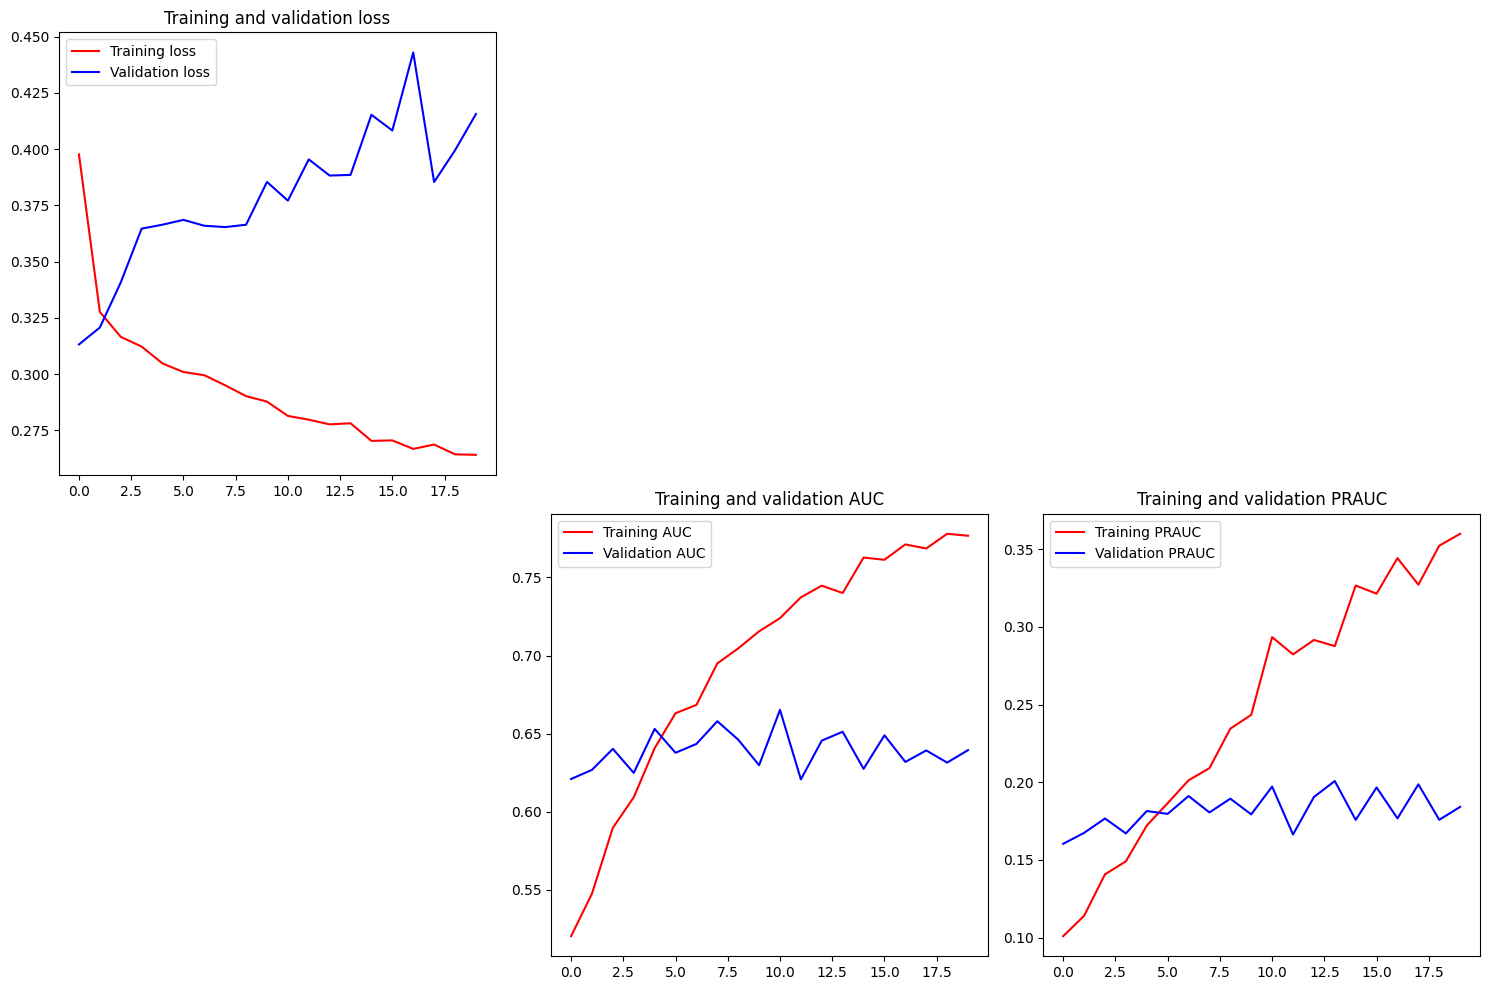

In [67]:
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plotting 
axs[0, 0].plot(epochs, loss, 'r', label='Training loss')
axs[0, 0].plot(epochs, val_loss, 'b', label='Validation loss')
axs[0, 0].set_title('Training and validation loss')
axs[0, 0].legend(loc=0)

# axs[0, 1].plot(epochs, recall, 'r', label='Training recall')
# axs[0, 1].plot(epochs, val_recall, 'b', label='Validation recall')
# axs[0, 1].set_title('Training and validation recall')
# axs[0, 1].legend(loc=0)
# Hide the empty subplot
axs[0, 1].axis('off')

# axs[0, 2].plot(epochs, precision, 'r', label='Training precision')
# axs[0, 2].plot(epochs, val_precision, 'b', label='Validation precision')
# axs[0, 2].set_title('Training and validation precision')
# axs[0, 2].legend(loc=0)
# Hide the empty subplot
axs[0, 2].axis('off')

# axs[1, 0].plot(epochs, f1_score, 'r', label='Training f1_score')
# axs[1, 0].plot(epochs, val_f1_score, 'b', label='Validation f1_score')
# axs[1, 0].set_title('Training and validation f1_score')
# axs[1, 0].legend(loc=0)
# Hide the empty subplot
axs[1, 0].axis('off')

axs[1, 1].plot(epochs, auc, 'r', label='Training AUC')
axs[1, 1].plot(epochs, val_auc, 'b', label='Validation AUC')
axs[1, 1].set_title('Training and validation AUC')
axs[1, 1].legend(loc=0)
# Hide the empty subplot
# axs[1, 1].axis('off')

axs[1, 2].plot(epochs, prauc, 'r', label='Training PRAUC')
axs[1, 2].plot(epochs, val_prauc, 'b', label='Validation PRAUC')
axs[1, 2].set_title('Training and validation PRAUC')
axs[1, 2].legend(loc=0)
# Hide the empty subplot
# axs[1, 2].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Get predictions

In [69]:
# # Transform the data
# X_test_selected = mi_selector.fit_transform(X_test, y_test)

# Predict using the test set
preds = model.predict(X_test)
print(preds)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.01894433]
 [0.08167683]
 [0.07168302]
 ...
 [0.00557157]
 [0.04709352]
 [0.13080907]]


In [70]:
y_pred = (preds >= 0.5).astype(np.int32)[:,0]
print(y_pred)

[0 0 0 ... 0 0 0]


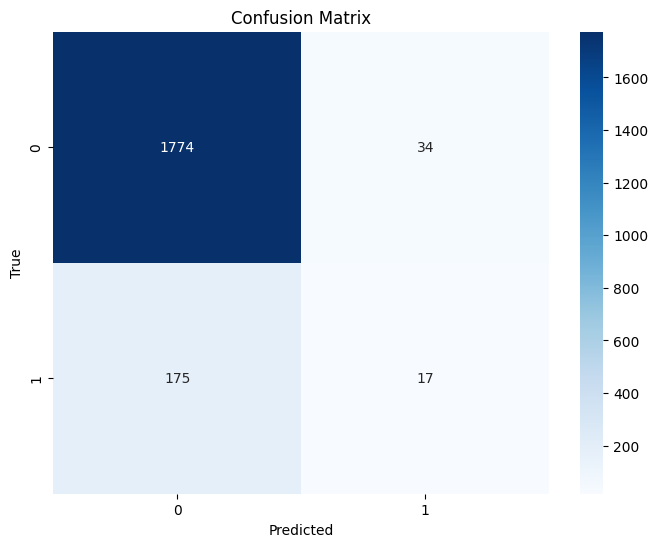

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1808
           1       0.33      0.09      0.14       192

    accuracy                           0.90      2000
   macro avg       0.62      0.53      0.54      2000
weighted avg       0.85      0.90      0.87      2000



In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize=None)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate classification report
report = classification_report(y_test, y_pred)
print(report)

In [72]:
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='macro')
test_recall = recall_score(y_test, y_pred, average='macro')
test_f1 = f1_score(y_test, y_pred, average='macro')
test_auc = roc_auc_score(y_test, y_pred)

print("Accuracy:", test_accuracy)
print('Precison:', test_precision)
print('Recall:', test_recall)
print('F1 Score:', test_f1)
print('AUC:', test_auc)

Accuracy: 0.8955
Precison: 0.6217718488113563
Recall: 0.5348681784660767
F1 Score: 0.5421441019288001
AUC: 0.5348681784660767
